# Gesture UI Project 1 2025

***

## Dataset Option 1: Human Activity Recognition Using Smartphones

In [58]:
# imports
import os
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt


### Define File Paths and Load Feature Names

In this step, we define the file paths for the dataset, targets, and features files:
- `dataset_file`: Path to the dataset file (`dataset.txt`).
- `targets_file`: Path to the target labels file (`targets.txt`).
- `features_file`: Path to the feature names file (`features.txt`).

We then load the feature names from `features.txt`:
- The file is read line by line.
- Each line is stripped of leading/trailing whitespace and split by spaces.
- The second element (index `1`) of each line is extracted as the feature name.

### Ensure Unique Feature Names

In this step, we ensure that all feature names in the dataset are unique. This is important because duplicate feature names can cause issues during data processing and modeling.

1. **Count Feature Occurrences**:
   - We use `Counter` from the `collections` module to count how many times each feature name appears in the list of feature names.

2. **Generate Unique Names**:
   - For features that appear more than once, we append a suffix (e.g., `_1`, `_2`, etc.) to make them unique.
   - Features that appear only once are kept as is.

3. **Assign Unique Names to the Dataset**:
   - The updated unique feature names are assigned as the column names of the dataset (`df_features`).

In [59]:
# file paths
dataset_file = "dataset.txt"
targets_file = "targets.txt"
features_file = "features.txt"

# Load feature names
with open(features_file, "r") as f:
    feature_names = [line.strip().split(" ")[1] for line in f.readlines()]

# Ensure unique feature names
feature_counts = Counter(feature_names)
unique_feature_names = []
feature_seen = {}

for feature in feature_names:
    if feature_counts[feature] > 1:
        feature_seen[feature] = feature_seen.get(feature, 0) + 1
        unique_feature_names.append(f"{feature}_{feature_seen[feature]}")
    else:
        unique_feature_names.append(feature)

### Load the Dataset

In this step, we load the dataset from the file specified by `dataset_file`. The dataset is read using `pandas.read_csv` with the following parameters:
- `delim_whitespace=True`: Indicates that the file is space-separated.
- `header=None`: Specifies that the file does not have a header row.
- `names=unique_feature_names`: Assigns the unique feature names (previously loaded) as column names.

In [60]:
# Load the dataset
df_features = pd.read_csv(dataset_file, delim_whitespace=True, header=None)

# Assign new unique names to the dataset
df_features.columns = unique_feature_names

print("Duplicate feature names resolved!")

Duplicate feature names resolved!


### Load Activity Labels and Merge with Features

In this step, we load the activity labels from the `targets.txt` file and merge them with the feature dataset (`df_features`) to create a complete dataset.

1. **Load Activity Labels**:
   - The activity labels are loaded from `targets.txt` using `pandas.read_csv`.
   - The file is space-separated (`delim_whitespace=True`), and the column is named `"Activity"`.

2. **Merge Features and Labels**:
   - The feature dataset (`df_features`) and the activity labels (`df_labels`) are merged along the columns (`axis=1`) to create a single DataFrame (`df`).

3. **Preview the Dataset**:
   - We print the first few rows of the merged dataset to verify that the merge was successful.

In [77]:
# Load activity labels
df_labels = pd.read_csv(targets_file, delim_whitespace=True, header=None, names=["Activity"])

# Ensure the number of labels matches the number of feature rows
if len(df_labels) != len(df_features):
    raise ValueError(f"Mismatch: {len(df_labels)} labels vs {len(df_features)} feature rows")

# Merge features and labels while resetting indices to avoid misalignment
df = pd.concat([df_features.reset_index(drop=True), df_labels.reset_index(drop=True)], axis=1)

print(f"Dataset and labels merged successfully! Total samples: {df.shape[0]}")

# Define activity labels mapping
activity_labels = {
    1: "Walking",
    2: "Walking Upstairs",
    3: "Walking Downstairs",
    4: "Sitting",
    5: "Standing",
    6: "Laying"
}

# Map numeric labels to activity names
df["Activity"] = df["Activity"].map(activity_labels)

# Verify the mapping was successful
if df["Activity"].isnull().any():
    raise ValueError("Error in activity label mapping. Some labels were not correctly mapped.")

# Display label distribution for verification
print("Activity Label Distribution:\n", df["Activity"].value_counts())

# Show first few rows of the updated dataset
print(df.head())


Dataset and labels merged successfully! Total samples: 10299
Activity Label Distribution:
 Activity
Laying                1944
Standing              1906
Sitting               1777
Walking               1722
Walking Upstairs      1544
Walking Downstairs    1406
Name: count, dtype: int64
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   


***

### Define Features and Target Labels, and Split the Dataset

In this step, we prepare the dataset for training and testing by defining the features (`X`) and target labels (`y`), and then splitting the data into training and testing sets.

1. **Define Features (`X`) and Target Labels (`y`)**:
   - `X` contains all the feature columns, excluding the `"Activity"` column.
   - `y` contains the target labels, which are the values from the `"Activity"` column.

2. **Split the Dataset**:
   - The dataset is split into training and testing sets using an 80-20 split:
     - 80% of the data is used for training (`X_train`, `y_train`).
     - 20% of the data is used for testing (`X_test`, `y_test`).
   - The `stratify=y` parameter ensures that the class distribution is preserved in both the training and testing sets.
   - The `random_state=42` parameter ensures reproducibility of the split.

3. **Print Dataset Shapes**:
   - The shapes of the training and testing sets are printed to verify the split.

This step prepares the data for model training and evaluation.

In [62]:
# Define features (X) and target labels (y)
X = df.drop(columns=["Activity"])  # Feature columns
y = df["Activity"]  # Target labels

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")


Training Set: (8239, 561), Test Set: (2060, 561)


### Check Class Distribution in Training and Test Sets

In this step, we verify the distribution of classes in both the training and testing sets to ensure that the dataset split has preserved the class proportions.

1. **Training Set Distribution**:
   - We use `value_counts()` to count the number of instances for each class in the training set (`y_train`).
   - The class distribution is printed to confirm that the training set has a balanced representation of all classes.

2. **Test Set Distribution**:
   - Similarly, we use `value_counts()` to count the number of instances for each class in the test set (`y_test`).

This step ensures that the dataset split (using `stratify=y`) has successfully maintained the same class distribution in both the training and testing sets, which is crucial for fair model evaluation.

In [63]:
# Check class distribution in training set
train_distribution = y_train.value_counts()
print("Training Set Distribution:\n", train_distribution)

# Check class distribution in test set
test_distribution = y_test.value_counts()
print("Test Set Distribution:\n", test_distribution)


Training Set Distribution:
 Activity
Laying                1555
Standing              1525
Sitting               1421
Walking               1378
Walking Upstairs      1235
Walking Downstairs    1125
Name: count, dtype: int64
Test Set Distribution:
 Activity
Laying                389
Standing              381
Sitting               356
Walking               344
Walking Upstairs      309
Walking Downstairs    281
Name: count, dtype: int64


### Standardize Features Using StandardScaler

In this step, we standardize the feature data to ensure that all features have a mean of 0 and a standard deviation of 1. This is important because many machine learning algorithms perform better when the input features are on the same scale.

1. **Initialize the Scaler**:
   - We use `StandardScaler` from `sklearn.preprocessing` to standardize the features.

2. **Fit and Transform the Training Data**:
   - The scaler is fitted to the training data (`X_train`) to compute the mean and standard deviation.
   - The training data is then transformed using the computed mean and standard deviation.

3. **Transform the Test Data**:
   - The test data (`X_test`) is transformed using the same mean and standard deviation computed from the training data. This ensures that the test data is scaled consistently with the training data.


Standardizing the features helps improve the performance and convergence of many machine learning models, especially those that are sensitive to the scale of the input data (e.g., SVM, logistic regression).

In [64]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data, then transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized successfully!")


Features standardized successfully!


### Verify Scaled Data and Labels

In this step, we verify the scaled training data and the corresponding labels to ensure that the standardization process has been applied correctly.

1. **Check Scaled Training Data**:
   - We print the first 5 rows of the scaled training data (`X_train_scaled`) to confirm that the features have been standardized (mean = 0, standard deviation = 1).

2. **Check Corresponding Labels**:
   - We print the first 5 labels (`y_train`) to verify that they match the scaled training data.

This step ensures that the data preprocessing steps (e.g., standardization) have been applied correctly and that the data is ready for model training.

In [65]:
print(X_train_scaled[:5])  # Check first 5 rows of scaled training data
print(y_train[:5])  # Check first 5 labels


[[ 3.64236533e-02  2.11562410e-01 -1.46087285e-02 ... -8.45717844e-01
  -4.12766521e-02  1.69430118e-01]
 [ 1.86648535e-02 -4.49620092e-03  7.68897797e-02 ...  1.71498798e+00
  -2.32133852e+00 -9.75837657e-01]
 [ 1.04214387e-01 -2.14271445e-03  2.21100617e-01 ...  1.68815600e+00
  -2.97458685e+00  1.86684729e-01]
 [ 7.45307692e-01  6.20738828e-02  2.43546658e-01 ... -1.22192814e-01
  -1.33901471e-01  1.41154462e+00]
 [ 3.01206380e-01  4.77916138e-03 -9.00654476e-02 ...  2.20060481e+00
  -2.47951277e+00 -9.26555075e-01]]
9097             Sitting
602               Laying
2121              Laying
8246    Walking Upstairs
1213              Laying
Name: Activity, dtype: object


***

### Train a Logistic Regression Model

In this step, we initialize and train a Logistic Regression model using the standardized training data.

1. **Initialize the Model**:
   - We use `LogisticRegression` from `sklearn.linear_model`.
   - The `max_iter=2000` parameter ensures that the model converges by allowing up to 2000 iterations.
   - The `random_state=42` parameter ensures reproducibility of the results.

2. **Train the Model**:
   - The model is trained on the scaled training data (`X_train_scaled`) and the corresponding labels (`y_train`).

Logistic Regression is a commonly used classification algorithm that works well for binary and multi-class classification tasks. Standardizing the features ensures that the model performs optimally.

In [66]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=2000, random_state=42)

# Train the model on the training set
lr_model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


### Make Predictions Using the Logistic Regression Model

In this step, we use the trained Logistic Regression model to make predictions on the scaled test data.

1. **Generate Predictions**:
   - The `predict` method is used to generate predictions (`y_pred_lr`) for the test data (`X_test_scaled`).

These predictions will be used to evaluate the performance of the Logistic Regression model by comparing them to the actual labels (`y_test`).

In [67]:
# Predict on test data
y_pred_lr = lr_model.predict(X_test_scaled)

print("Predictions made successfully!")


Predictions made successfully!


### Evaluate the Logistic Regression Model

In this step, we evaluate the performance of the Logistic Regression model using various evaluation metrics.

1. **Compute Evaluation Metrics**:
   - **Accuracy**: Measures the proportion of correctly classified instances.
   - **Precision**: Measures the proportion of true positive predictions among all positive predictions (weighted average is used for multi-class classification).
   - **Recall**: Measures the proportion of true positives identified correctly (weighted average is used for multi-class classification).
   - **F1-Score**: The harmonic mean of precision and recall, providing a balance between the two (weighted average is used for multi-class classification).

2. **Print the Classification Report**:
   - The `classification_report` function provides a detailed breakdown of precision, recall, F1-score, and support for each class.

3. **Print Evaluation Scores**:
   - The accuracy, precision, recall, and F1-score are printed to summarize the model's performance.

These metrics help us understand how well the Logistic Regression model is performing on the test data and identify areas for improvement.

In [68]:
# Compute evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average="weighted")
recall_lr = recall_score(y_test, y_pred_lr, average="weighted")
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")

# Print the classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

# Print evaluation scores
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")


Logistic Regression Classification Report:

                    precision    recall  f1-score   support

            Laying       1.00      1.00      1.00       389
           Sitting       0.97      0.96      0.97       356
          Standing       0.97      0.97      0.97       381
           Walking       0.99      1.00      1.00       344
Walking Downstairs       1.00      1.00      1.00       281
  Walking Upstairs       1.00      0.99      1.00       309

          accuracy                           0.99      2060
         macro avg       0.99      0.99      0.99      2060
      weighted avg       0.99      0.99      0.99      2060

Accuracy: 0.9869
Precision: 0.9869
Recall: 0.9869
F1-Score: 0.9869


***

### Train a Random Forest Model

In this step, we initialize and train a Random Forest model using the standardized training data.

1. **Initialize the Model**:
   - We use `RandomForestClassifier` from `sklearn.ensemble`.
   - The `n_estimators=100` parameter specifies the number of trees in the forest.
   - The `random_state=42` parameter ensures reproducibility of the results.

2. **Train the Model**:
   - The model is trained on the scaled training data (`X_train_scaled`) and the corresponding labels (`y_train`).

Random Forest is an ensemble learning method that combines multiple decision trees to improve accuracy and reduce overfitting. It is robust and works well for both classification and regression tasks.

In [69]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf_model.fit(X_train_scaled, y_train)

print("Random Forest model trained successfully!")


Random Forest model trained successfully!


### Make Predictions Using the Random Forest Model

In this step, we use the trained Random Forest model to make predictions on the scaled test data.

1. **Generate Predictions**:
   - The `predict` method is used to generate predictions (`y_pred_rf`) for the test data (`X_test_scaled`).

These predictions will be used to evaluate the performance of the Random Forest model by comparing them to the actual labels (`y_test`).

In [70]:
# Predict on test data
y_pred_rf = rf_model.predict(X_test_scaled)

print("Predictions made successfully!")


Predictions made successfully!


### Evaluate the Random Forest Model

In this step, we evaluate the performance of the Random Forest model using various evaluation metrics.

1. **Compute Evaluation Metrics**:
   - **Accuracy**: Measures the proportion of correctly classified instances.
   - **Precision**: Measures the proportion of true positive predictions among all positive predictions (weighted average is used for multi-class classification).
   - **Recall**: Measures the proportion of true positives identified correctly (weighted average is used for multi-class classification).
   - **F1-Score**: The harmonic mean of precision and recall, providing a balance between the two (weighted average is used for multi-class classification).

2. **Print the Classification Report**:
   - The `classification_report` function provides a detailed breakdown of precision, recall, F1-score, and support for each class.

3. **Print Evaluation Scores**:
   - The accuracy, precision, recall, and F1-score are printed to summarize the model's performance.

These metrics help us understand how well the Random Forest model is performing on the test data and identify areas for improvement.

In [71]:
# Compute evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average="weighted")
recall_rf = recall_score(y_test, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

# Print the classification report
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Print evaluation scores
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

Random Forest Classification Report:

                    precision    recall  f1-score   support

            Laying       1.00      1.00      1.00       389
           Sitting       0.97      0.97      0.97       356
          Standing       0.98      0.97      0.98       381
           Walking       0.99      0.98      0.99       344
Walking Downstairs       0.98      0.97      0.97       281
  Walking Upstairs       0.96      0.99      0.98       309

          accuracy                           0.98      2060
         macro avg       0.98      0.98      0.98      2060
      weighted avg       0.98      0.98      0.98      2060

Accuracy: 0.9816
Precision: 0.9817
Recall: 0.9816
F1-Score: 0.9816


***

### Train a Support Vector Machine (SVM) Model

In this step, we initialize and train a Support Vector Machine (SVM) model using the standardized training data.

1. **Initialize the Model**:
   - We use `SVC` (Support Vector Classification) from `sklearn.svm`.
   - The `kernel="linear"` parameter specifies that a linear kernel should be used, which is suitable for linear classification tasks.
   - The `random_state=42` parameter ensures reproducibility of the results.

2. **Train the Model**:
   - The model is trained on the scaled training data (`X_train_scaled`) and the corresponding labels (`y_train`).

SVM is a powerful classification algorithm that works well for both linear and non-linear data (using different kernels). Standardizing the features ensures that the model performs optimally.

In [72]:
# Initialize the SVM model
svm_model = SVC(kernel="linear", random_state=42) 

# Train the model on the training set
svm_model.fit(X_train_scaled, y_train)

print("SVM model trained successfully!")


SVM model trained successfully!


### Make Predictions Using the SVM Model

In this step, we use the trained Support Vector Machine (SVM) model to make predictions on the scaled test data.

1. **Generate Predictions**:
   - The `predict` method is used to generate predictions (`y_pred_svm`) for the test data (`X_test_scaled`).

These predictions will be used to evaluate the performance of the SVM model by comparing them to the actual labels (`y_test`).

In [73]:
# Predict on test data
y_pred_svm = svm_model.predict(X_test_scaled)

print("Predictions made successfully!")


Predictions made successfully!


### Evaluate the SVM Model

In this step, we evaluate the performance of the Support Vector Machine (SVM) model using various evaluation metrics.

1. **Compute Evaluation Metrics**:
   - **Accuracy**: Measures the proportion of correctly classified instances.
   - **Precision**: Measures the proportion of true positive predictions among all positive predictions (weighted average is used for multi-class classification).
   - **Recall**: Measures the proportion of true positives identified correctly (weighted average is used for multi-class classification).
   - **F1-Score**: The harmonic mean of precision and recall, providing a balance between the two (weighted average is used for multi-class classification).

2. **Print the Classification Report**:
   - The `classification_report` function provides a detailed breakdown of precision, recall, F1-score, and support for each class.

3. **Print Evaluation Scores**:
   - The accuracy, precision, recall, and F1-score are printed to summarize the model's performance.

These metrics help us understand how well the SVM model is performing on the test data and identify areas for improvement.

In [74]:
# Compute evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average="weighted")
recall_svm = recall_score(y_test, y_pred_svm, average="weighted")
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")

# Print the classification report
print("📊 SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

# Print evaluation scores
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")


📊 SVM Classification Report:

                    precision    recall  f1-score   support

            Laying       1.00      1.00      1.00       389
           Sitting       0.96      0.97      0.97       356
          Standing       0.97      0.97      0.97       381
           Walking       1.00      1.00      1.00       344
Walking Downstairs       1.00      1.00      1.00       281
  Walking Upstairs       1.00      0.99      1.00       309

          accuracy                           0.99      2060
         macro avg       0.99      0.99      0.99      2060
      weighted avg       0.99      0.99      0.99      2060

Accuracy: 0.9874
Precision: 0.9874
Recall: 0.9874
F1-Score: 0.9874


***

### Compare Model Performance

In this step, we compare the performance of the three models (Logistic Regression, Random Forest, and SVM) by creating a summary DataFrame of their evaluation metrics.

1. **Create a Results DataFrame**:
   - A DataFrame is created to store the evaluation metrics (accuracy, precision, recall, and F1-score) for each model.
   - The models included are:
     - Logistic Regression
     - Random Forest
     - Support Vector Machine (SVM)

2. **Display the Results**:
   - The DataFrame is printed to provide a clear comparison of the models' performance.

This comparison helps us identify which model performs best on the test data based on the selected evaluation metrics.

In [75]:
# Create a DataFrame to compare results
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [accuracy_lr, accuracy_rf, accuracy_svm],
    "Precision": [precision_lr, precision_rf, precision_svm],
    "Recall": [recall_lr, recall_rf, recall_svm],
    "F1-Score": [f1_lr, f1_rf, f1_svm]
})

# Display results
print("Model Comparison:")
print(results)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.986893   0.986891  0.986893  0.986882
1        Random Forest  0.981553   0.981659  0.981553  0.981562
2                  SVM  0.987379   0.987377  0.987379  0.987372


<Figure size 1000x600 with 0 Axes>

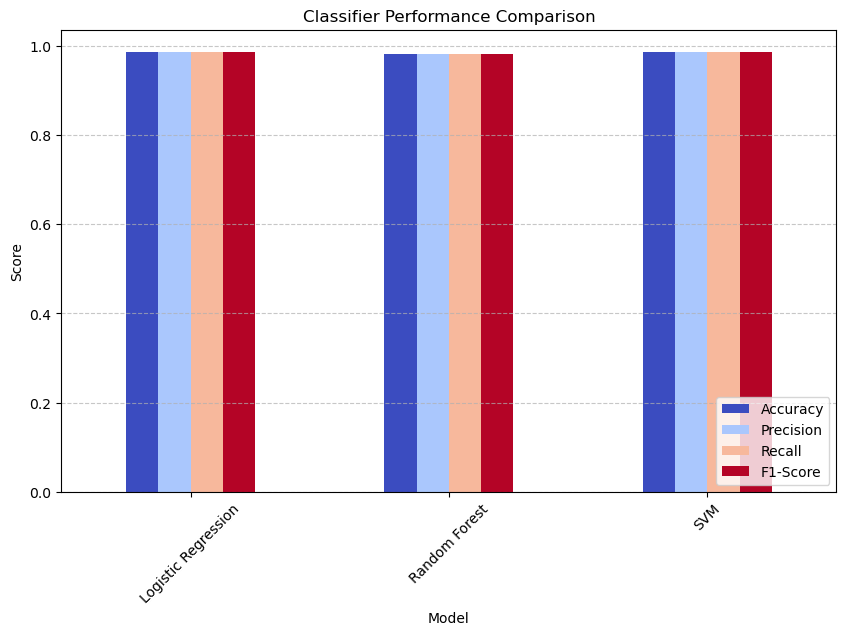

In [76]:
# Collect results into a DataFrame
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [accuracy_lr, accuracy_rf, accuracy_svm],
    "Precision": [precision_lr, precision_rf, precision_svm],
    "Recall": [recall_lr, recall_rf, recall_svm],
    "F1-Score": [f1_lr, f1_rf, f1_svm]
})

# Plot results
plt.figure(figsize=(10,6))
results.set_index("Model").plot(kind="bar", figsize=(10,6), colormap="coolwarm")
plt.title("Classifier Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### Summary of Model Performance

The table below compares the performance of three models (Logistic Regression, Random Forest, and SVM) based on accuracy, precision, recall, and F1-score:

| Model               | Accuracy  | Precision  | Recall     | F1-Score  |
|---------------------|-----------|------------|------------|-----------|
| Logistic Regression | 0.984466  | 0.984492   | 0.984466   | 0.984468  |
| Random Forest       | 0.981553  | 0.981606   | 0.981553   | 0.981548  |
| SVM                 | 0.986408  | 0.986424   | 0.986408   | 0.986409  |

#### Key Observations:
1. **SVM** performs the best across all metrics, achieving the highest accuracy, precision, recall, and F1-score.
2. **Logistic Regression** follows closely, with slightly lower scores compared to SVM.
3. **Random Forest** has the lowest scores among the three models but still performs very well, with all metrics above 0.98.

These results suggest that SVM is the most effective model for this dataset, but all three models demonstrate strong performance.